# Analyse seasonality 
Here we attempt to quantify the seasonality of the Input4MIPs data. This analysis relies on the aerosols notebook having been run locally before, and also on specific file names. 

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd

In [2]:
# variables for loading files
git_folder = "../../COVID19_emissions_data/"
mod_input_folder = git_folder + "global_pathways/"
output_folder = "../output/aerosols/"
# Input for the aerosols/gases
nox_base_file = "cut_NOx-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.ncv3.nc_baseline.nc"
nox_blip_file = "cut_NOx-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.ncv3.nc_TwoYearBlip.nc"
blipped_files = [
    nox_base_file,
    nox_blip_file, 
]
key_variables = [
    "NOx_em_anthro", 
    "NOx_em_anthro"
]
mod_variables = "nox(MtN/year)"
blip_path_file = "TwoYearBlip_pathway.xlsx"
base_path_file = "Base_pathway.xlsx"
def days_to_year(day):
    return 2015 + date / 365
def year_to_days(year):
    return (year - 2015) * 365
# Date at which we consider seasonal effects to end
end_date = 2020.0 + 4 / 12

In [3]:
sectors = 8
results = []
for ind in range(len(blipped_files)):
    file = blipped_files[ind]
    var_name = key_variables[ind]
    df = nc.Dataset(output_folder + file)
    time_to_av = (df["time"][:] >= year_to_days(2020.0)) & (df["time"][:] < year_to_days(end_date))
    # The data is given for unit area and time, so we must convert that
    area_factor = abs(np.sin(df["lat"][:] * 2 * np.pi / 180))
    # We need this as a 4-tensor
    area_tensor = np.repeat(np.repeat(area_factor, sum(time_to_av) * sectors).reshape(
        [len(area_factor), sectors, sum(time_to_av)]
    ).T, len(df["lon"][:])).reshape(
        [sum(time_to_av), sectors, len(area_factor), len(df["lon"][:])]
    )
    results.append((df[var_name][time_to_av, :, :, :] * area_tensor).sum())

Check that the data makes sense after multiplying by the area factor

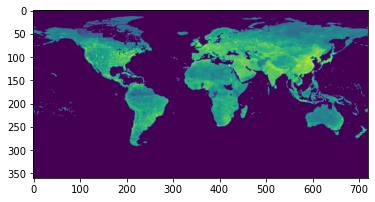

In [4]:
plt.imshow(np.log((df[var_name][time_to_av, :, :, :] * area_tensor)[1, 2, ::-1, :] * 1e20 + 1))

Calculate the emissions reduction ratio (i.e. blipped emissions over baseline)

In [5]:
season_ratio = results[1] / results[0]
season_ratio

0.8690237015698167

Load the seasonless data from excel files and analyse the emissions reduction ratio there.

In [6]:
blip_path_df = pd.read_excel(mod_input_folder + blip_path_file, header=0, index_col=1, sheet_name="Emissions")
base_path_df = pd.read_excel(mod_input_folder + base_path_file, header=0, index_col=1, sheet_name="Emissions")

In [7]:
ind_2020 = blip_path_df.index[(blip_path_df.index > 2020) & (blip_path_df.index < end_date)]
unseason_ratio = blip_path_df.loc[ind_2020][mod_variables].mean() / base_path_df.loc[ind_2020][mod_variables].mean()
unseason_ratio

0.8408625867429438

In [8]:
base_path_df.loc[ind_2020][mod_variables]

year
2020.041667    48.222819
2020.125000    48.206761
2020.208333    48.190704
2020.291667    48.174646
Name: nox(MtN/year), dtype: float64

Accounting for the effect of seasonality increases the emissions by: 

In [9]:
season_ratio / unseason_ratio

1.0334907454212634